In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
from os import path
import os

import astropy.coordinates as coord
from astropy.constants import G
from astropy.io import fits
from astropy.table import Table, QTable, join
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm
import yaml

import emcee

from hq.config import HQ_CACHE_PATH, config_to_alldata, config_to_jokerparams
from hq.plot import plot_two_panel, plot_phase_fold
from hq.data import get_rvdata
from hq.physics_helpers import period_at_surface, stellar_radius

from thejoker.plot import plot_rv_curves
from thejoker import JokerSamples, JokerParams, TheJoker

from scipy.special import logsumexp
from scipy.stats import beta, truncnorm
from scipy.optimize import minimize

%aimport -numpy, scipy, astropy, tqdm, emcee

In [5]:
samples_path = path.join(HQ_CACHE_PATH, 'dr16/samples')
metadata = QTable.read(path.join(HQ_CACHE_PATH, 'dr16/metadata-master.fits'))

with open(path.join(HQ_CACHE_PATH, "dr16/config.yml"), "r") as f:
    config = yaml.load(f.read())
allstar, allvisit = config_to_alldata(config)

In [6]:
metadata = join(metadata, allstar, keys='APOGEE_ID')

As an initial demonstration, select a good pixel in the HR diagram and only run in there:

/mnt/home/apricewhelan/anaconda3/envs/hq/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


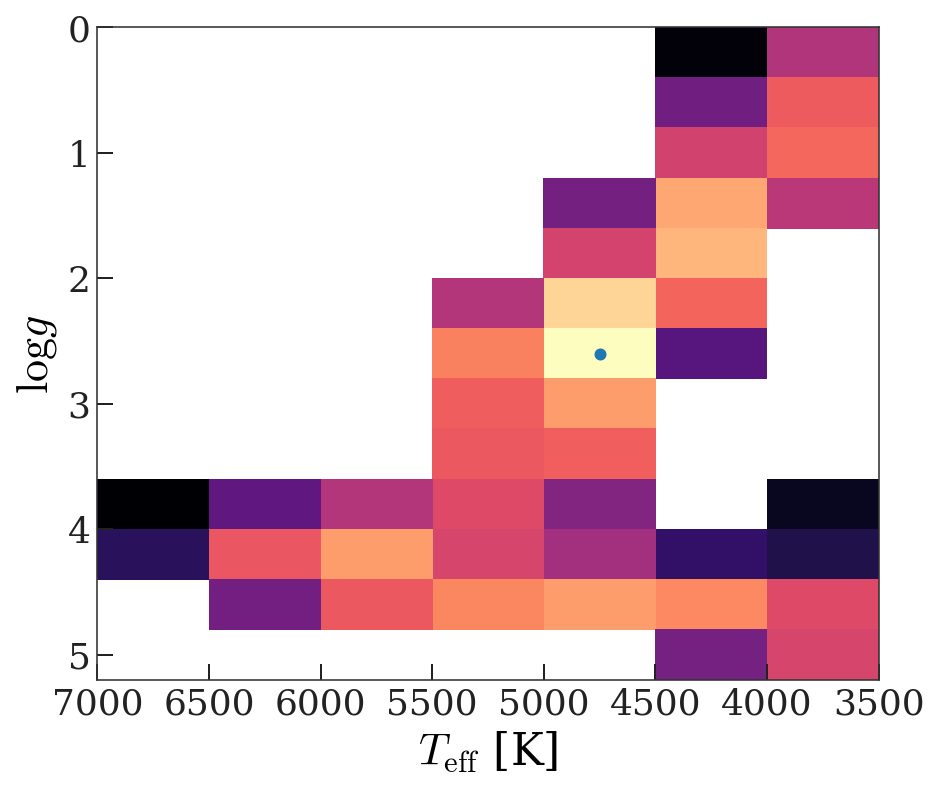

In [7]:
bins = (np.arange(3500, 7000+1e-3, 500),
        np.arange(0, 5.5+1e-3, 0.4))
H, xe, ye = np.histogram2d(allstar['TEFF'], allstar['LOGG'],
                           bins=bins)
H[H < 64] = np.nan

fig, ax = plt.subplots(1, 1, figsize=(7, 6))
im = ax.pcolormesh(xe, ye, H.T, norm=mpl.colors.LogNorm())
cell = [4750, 2.6]
# cell = [4750, 4.6]
ax.scatter(*cell)
ax.set_xlim(bins[0].max(), bins[0].min())
ax.set_ylim(bins[1].max(), bins[1].min())

ax.set_xlabel(r'$T_{\rm eff}$ [K]')
ax.set_ylabel(r'$\log g$')

fig.set_facecolor('w')

In [8]:
pixel_mask = ((np.abs(metadata['TEFF'] - cell[0]) < 500) & 
              (np.abs(metadata['LOGG'] - cell[1]) < 0.2))
llr_mask = (metadata['max_unmarginalized_ln_likelihood'] - metadata['robust_constant_ln_likelihood']) > 8
mask = (pixel_mask & llr_mask & 
        (metadata['unimodal'] | (metadata['joker_completed'] & (metadata['n_visits'] >= 8))))
#          ((metadata['n_visits'] >= 8) & metadata['joker_completed'] & (metadata['SNR'] > 250))))
pixel_mask.sum(), mask.sum()

(46053, 476)

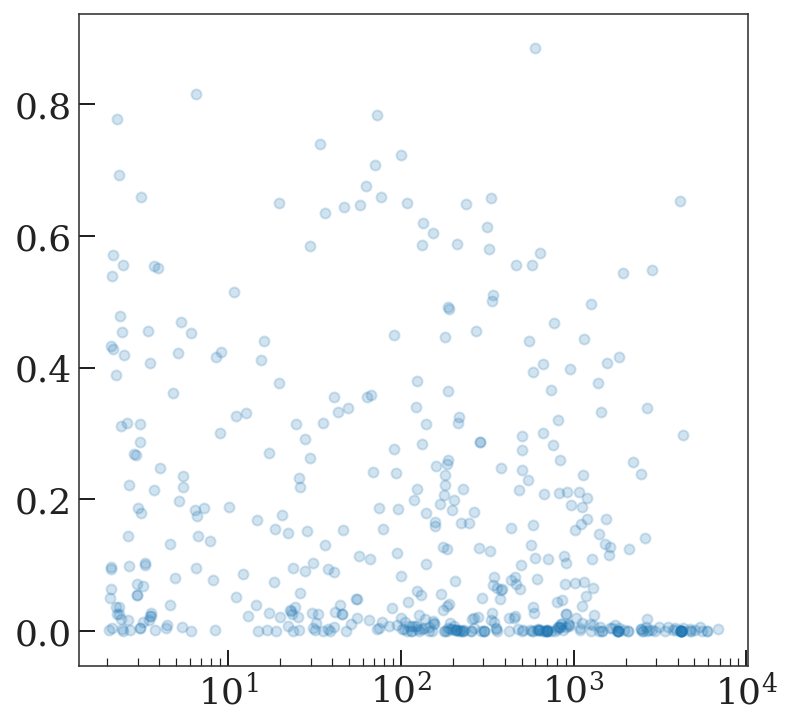

In [10]:
fig, ax = plt.subplots()
ax.scatter(metadata['MAP_P'][mask], # & metadata['unimodal']], 
           metadata['MAP_e'][mask], # & metadata['unimodal']],
           alpha=0.2) 
ax.set_xscale('log')

In [11]:
# for apogee_id in metadata[mask]['APOGEE_ID'][(metadata[mask]['MAP_P'] < 200*u.day) & (metadata[mask]['MAP_P'] > 100*u.day) & (metadata[mask]['MAP_e'] < 0.05)][:5]:
#     filename = path.join(samples_path, apogee_id[:4],
#                          '{}.fits.gz'.format(apogee_id))
#     samples = JokerSamples.from_table(filename) 

#     _visits = allvisit[allvisit['APOGEE_ID'] == apogee_id]
#     data = get_rvdata(_visits)
#     fig = plot_two_panel(data, samples, title='{}'.format(apogee_id))

Load all samples for the pixel:

In [12]:
NSAMPLES = 256

In [13]:
ez_samples = np.full((2, mask.sum(), NSAMPLES), np.nan)
for n, apogee_id in tqdm(enumerate(metadata[mask]['APOGEE_ID']), 
                         total=mask.sum()):
    filename = path.join(samples_path, apogee_id[:4],
                         '{}.fits.gz'.format(apogee_id))
    t = fits.getdata(filename)
    K = min(NSAMPLES, len(t))
    ez_samples[0, n, :K] = t['e'][:K]
    ez_samples[1, n, :K] = np.log(t['P'][:K])

100%|██████████| 476/476 [00:25<00:00, 18.82it/s]


In [201]:
B1 = beta(1.5, 50.)
B2 = beta(1, 1.8)

In [202]:
# FAKE = True
FAKE = False

---

# FAKE DATA

In [203]:
if FAKE:
    true_pars = {'k': 2., 'z0': 5.1, 'alpha0': 0.4, 
                 'muz': 6.523, 'lnsigz': np.log(1.545)}

    mod = Model([0., 0.], [1], None, B1=B1, B2=B2)
    zgrid = np.linspace(mod._zlim[0], mod._zlim[1], 1024)
    egrid = np.linspace(0, 1, 1024)
    zz, ee = np.meshgrid(zgrid, egrid)
    _val = np.exp(np.sum(mod.ln_ze_dens(true_pars, ee, zz), axis=0))
    max_val = _val[np.isfinite(_val)].max()

In [204]:
if FAKE:
    sim_n_requested = 255
    _N = 10000
    trial_e = np.random.uniform(0, 1, size=_N)
    trial_z = np.random.uniform(*mod._zlim, size=_N)
    trial_y = np.random.uniform(0, max_val, size=_N)
    trial_mask = trial_y < np.exp(np.sum(mod.ln_ze_dens(true_pars, trial_e, trial_z), axis=0))
    assert trial_mask.sum() > sim_n_requested

    sim_e = trial_e[trial_mask][:sim_n_requested]
    sim_z = trial_z[trial_mask][:sim_n_requested]

    sim_e = np.random.normal(sim_e, 1e-3, size=(NSAMPLES, len(sim_e))).T
    sim_z = np.random.normal(sim_z, 1e-3, size=(NSAMPLES, len(sim_z))).T

    ez_samples = np.stack((sim_e, sim_z))

---

(0, 1)

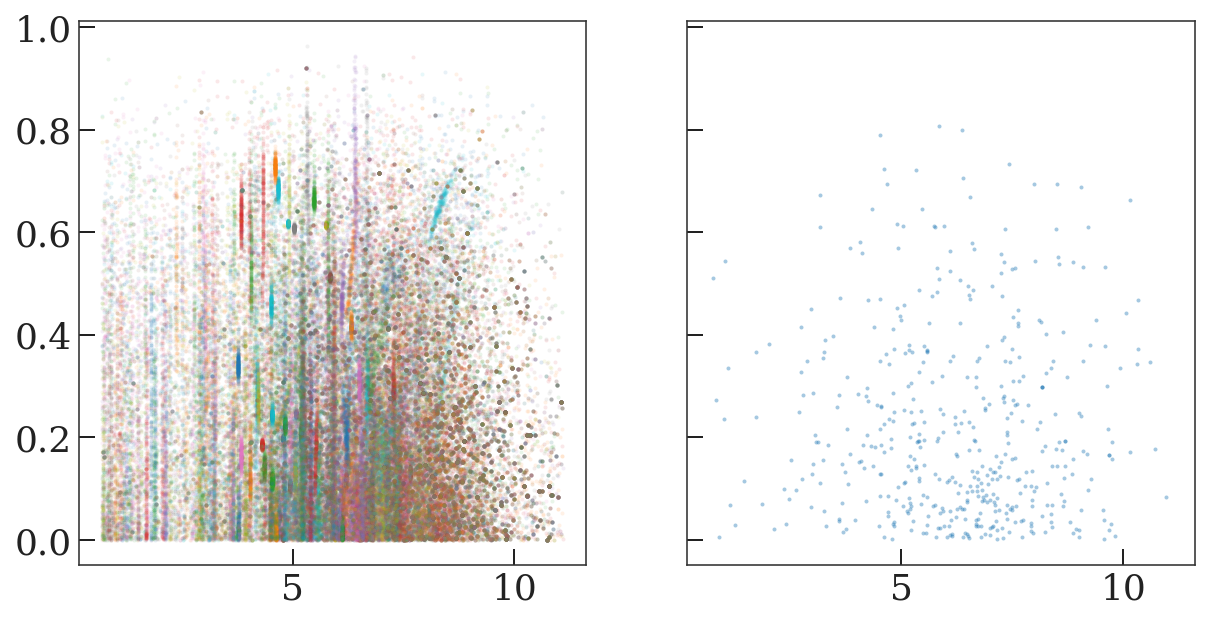

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), 
                         sharex=True, sharey=True)

axes[0].plot(ez_samples[1].T, ez_samples[0].T, 
             marker='o', ls='none', alpha=0.1, ms=2, mew=0);
axes[1].plot(ez_samples[1, :, -1], ez_samples[0, :, -1], 
             marker='o', ls='none', alpha=0.4, ms=2, mew=0);

# ax.set_xlim(zgrid.min(), zgrid.max())
ax.set_ylim(0, 1)

Number of samples for each star:

In [17]:
K_n = np.isfinite(ez_samples[0]).sum(axis=-1)
K_n_mask = K_n > 32
(~K_n_mask).sum()

0

In [18]:
# for apogee_id in metadata[mask]['APOGEE_ID'][~K_n_mask]:
#     filename = path.join(samples_path, apogee_id[:4],
#                          '{}.fits.gz'.format(apogee_id))
#     samples = JokerSamples.from_table(filename) 

#     _visits = allvisit[allvisit['APOGEE_ID'] == apogee_id]
#     data = get_rvdata(_visits)
#     fig = plot_two_panel(data, samples, title='{}'.format(apogee_id))

Re-compute the prior probability at the location of each sample:

In [19]:
ln_e_p0 = beta.logpdf(ez_samples[0], a=0.867, b=3.03)
ln_z_p0 = np.full_like(ez_samples[1], 
                       -np.log(np.log(65536) - np.log(2)))
ln_p0_ez = np.stack((ln_e_p0, ln_z_p0))

For nulling out the probability for samples that don't exist:

In [20]:
# for nulling out the probability for non-existing samples
nan_mask = np.zeros_like(ez_samples)
nan_mask[np.isnan(ez_samples)] = -np.inf

Class for evaluating the log-posterior of the hierarchical model:

In [21]:
from hq.hierarchical.period_ecc import Model

In [22]:
mod = Model(ez_samples, K_n, ln_p0_ez, B1=B1, B2=B2)
# p0 = mod.pack_pars({'k': 1., 'z0': np.log(30.), 'alpha0': 0.2,
p0 = mod.pack_pars({'lnk': 0., 'z0': np.log(30.), 'alpha0': 0.2,
                    'muz': np.log(100), 'lnsigz': np.log(4.)})
mod(p0)

NameError: name 'B1' is not defined

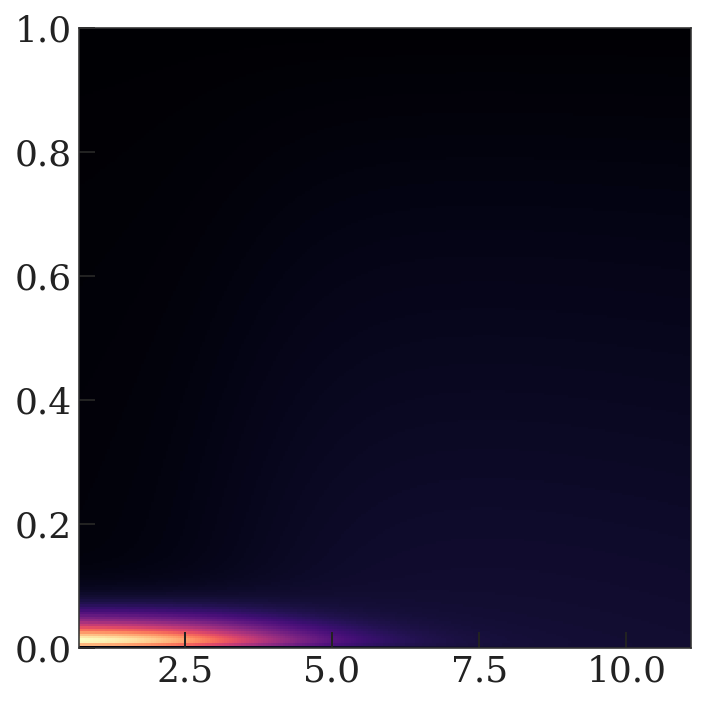

In [217]:
zgrid = np.linspace(mod._zlim[0], mod._zlim[1], 252)
egrid = np.linspace(0, 1, 256)
zz, ee = np.meshgrid(zgrid, egrid)
lnval_init = np.sum(mod.ln_ze_dens(mod.unpack_pars(p0), ee, zz), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.pcolormesh(zz, ee, np.exp(lnval_init))
fig.tight_layout()

---

In [218]:
res = minimize(lambda *args: -mod(*args), x0=p0, method='powell')

In [219]:
mod.unpack_pars(res.x)

{'lnk': 3.9994956231834276,
 'z0': 10.897361996942935,
 'alpha0': 0.7099003143717099,
 'muz': 6.3056145412014954,
 'lnsigz': 0.21808806184124138}

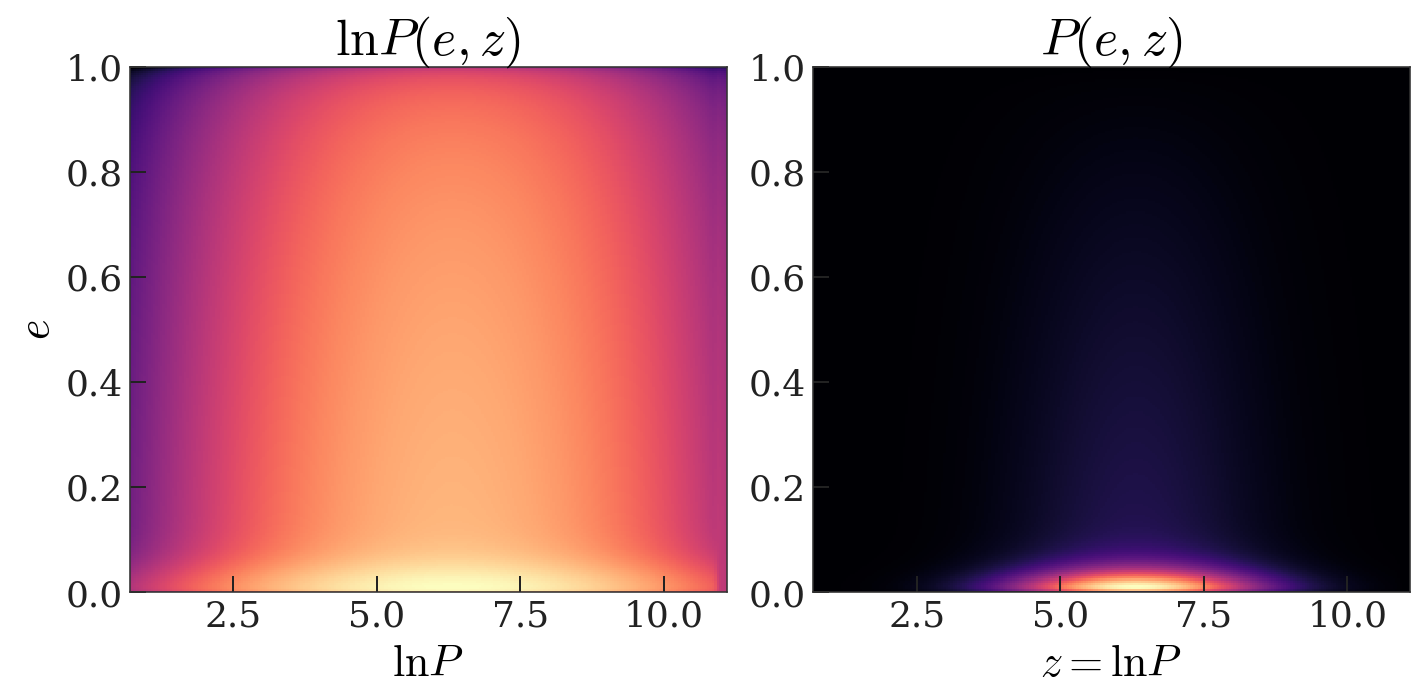

In [220]:
lnval_fit = np.sum(mod.ln_ze_dens(mod.unpack_pars(res.x), ee, zz), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pcolormesh(zz, ee, lnval_fit)
axes[1].pcolormesh(zz, ee, np.exp(lnval_fit))

axes[0].set_xlabel(r'$\ln P$')
axes[0].set_ylabel(r'$e$')
axes[1].set_xlabel(r'$z = \ln P$')

axes[0].set_title(r'$\ln P(e, z)$')
axes[1].set_title(r'$P(e, z)$')

fig.tight_layout()

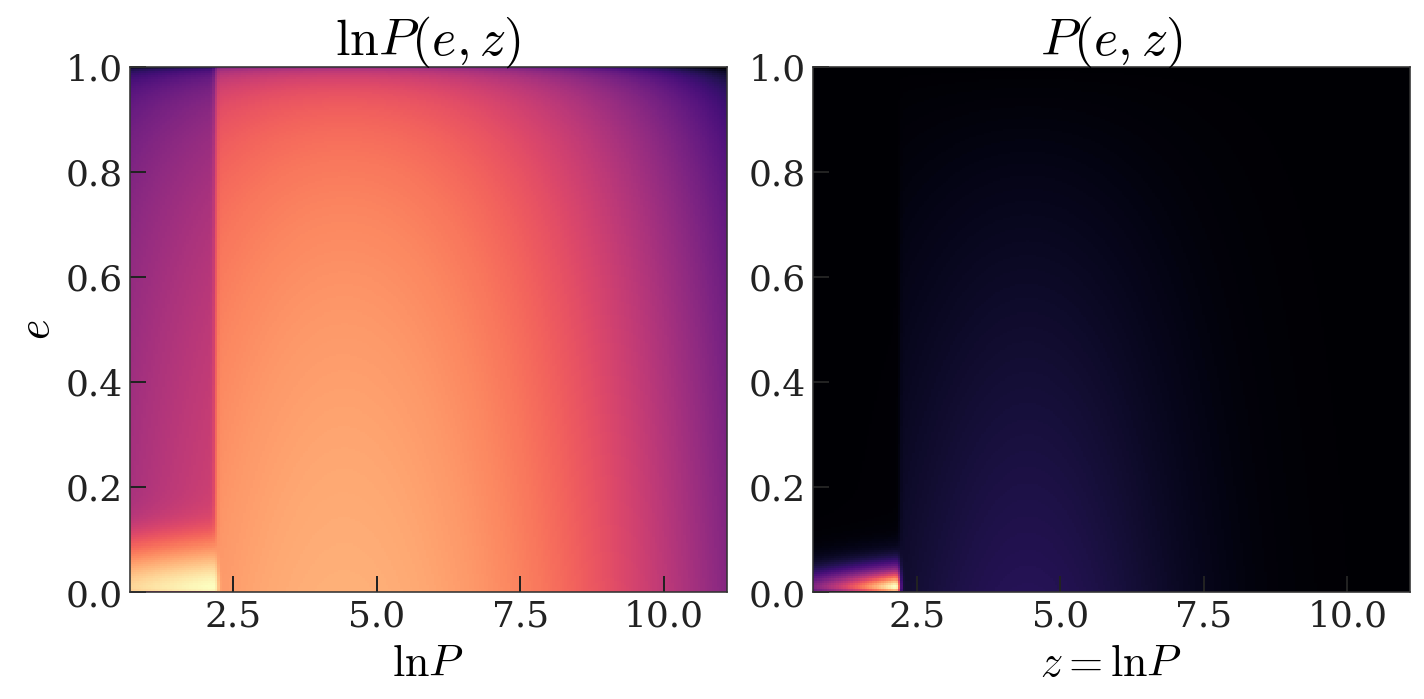

In [118]:
lnval_fit = np.sum(mod.ln_ze_dens(mod.unpack_pars(res.x), ee, zz), axis=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].pcolormesh(zz, ee, lnval_fit)
axes[1].pcolormesh(zz, ee, np.exp(lnval_fit))

axes[0].set_xlabel(r'$\ln P$')
axes[0].set_ylabel(r'$e$')
axes[1].set_xlabel(r'$z = \ln P$')

axes[0].set_title(r'$\ln P(e, z)$')
axes[1].set_title(r'$P(e, z)$')

fig.tight_layout()

In [119]:
e_lnw, z_lnw = mod.get_lnweights(mod.unpack_pars(res.x))

e_w = np.exp(e_lnw)
z_w = np.exp(z_lnw)

wi = e_w / np.sum(e_w, axis=1)[:, None]
K_eff_e = 1 / np.sum(wi**2, axis=1)

wi = z_w / np.sum(z_w, axis=1)[:, None]
K_eff_z = 1 / np.sum(wi**2, axis=1)

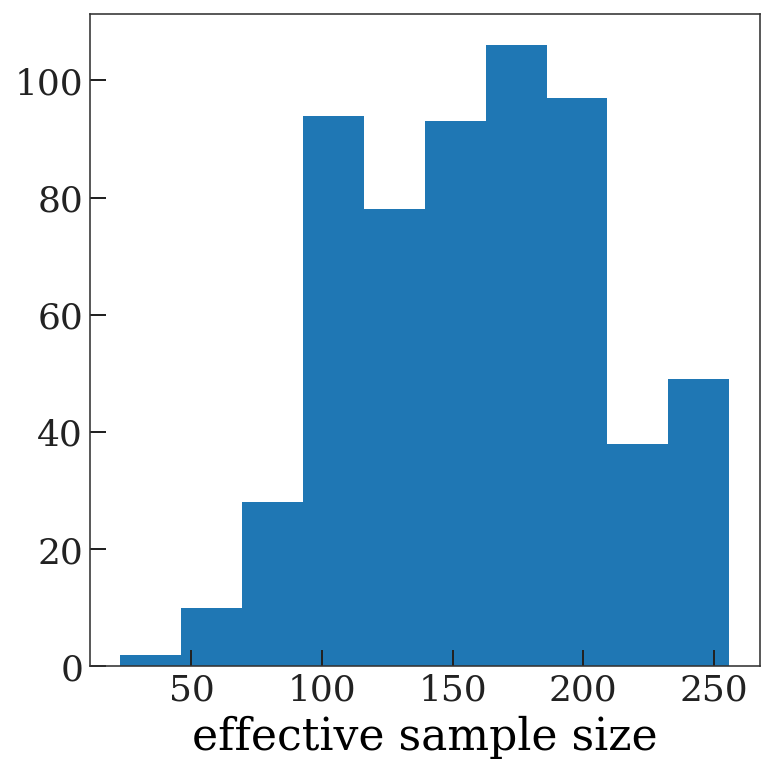

In [120]:
fig = plt.figure()
plt.hist(K_eff_e)
plt.xlabel('effective sample size')
fig.set_facecolor('w')

---

In [36]:
nparams = len(res.x)
nwalkers = 8 * nparams
all_p0 = emcee.utils.sample_ball(p0, [1e-3] * nparams, size=nwalkers)
nwalkers

40

In [37]:
sampler = emcee.EnsembleSampler(nwalkers=nwalkers, 
                                ndim=nparams, 
                                log_prob_fn=mod)
_ = sampler.run_mcmc(all_p0, 512, progress=True)

100%|██████████| 512/512 [47:54<00:00,  5.74s/it]


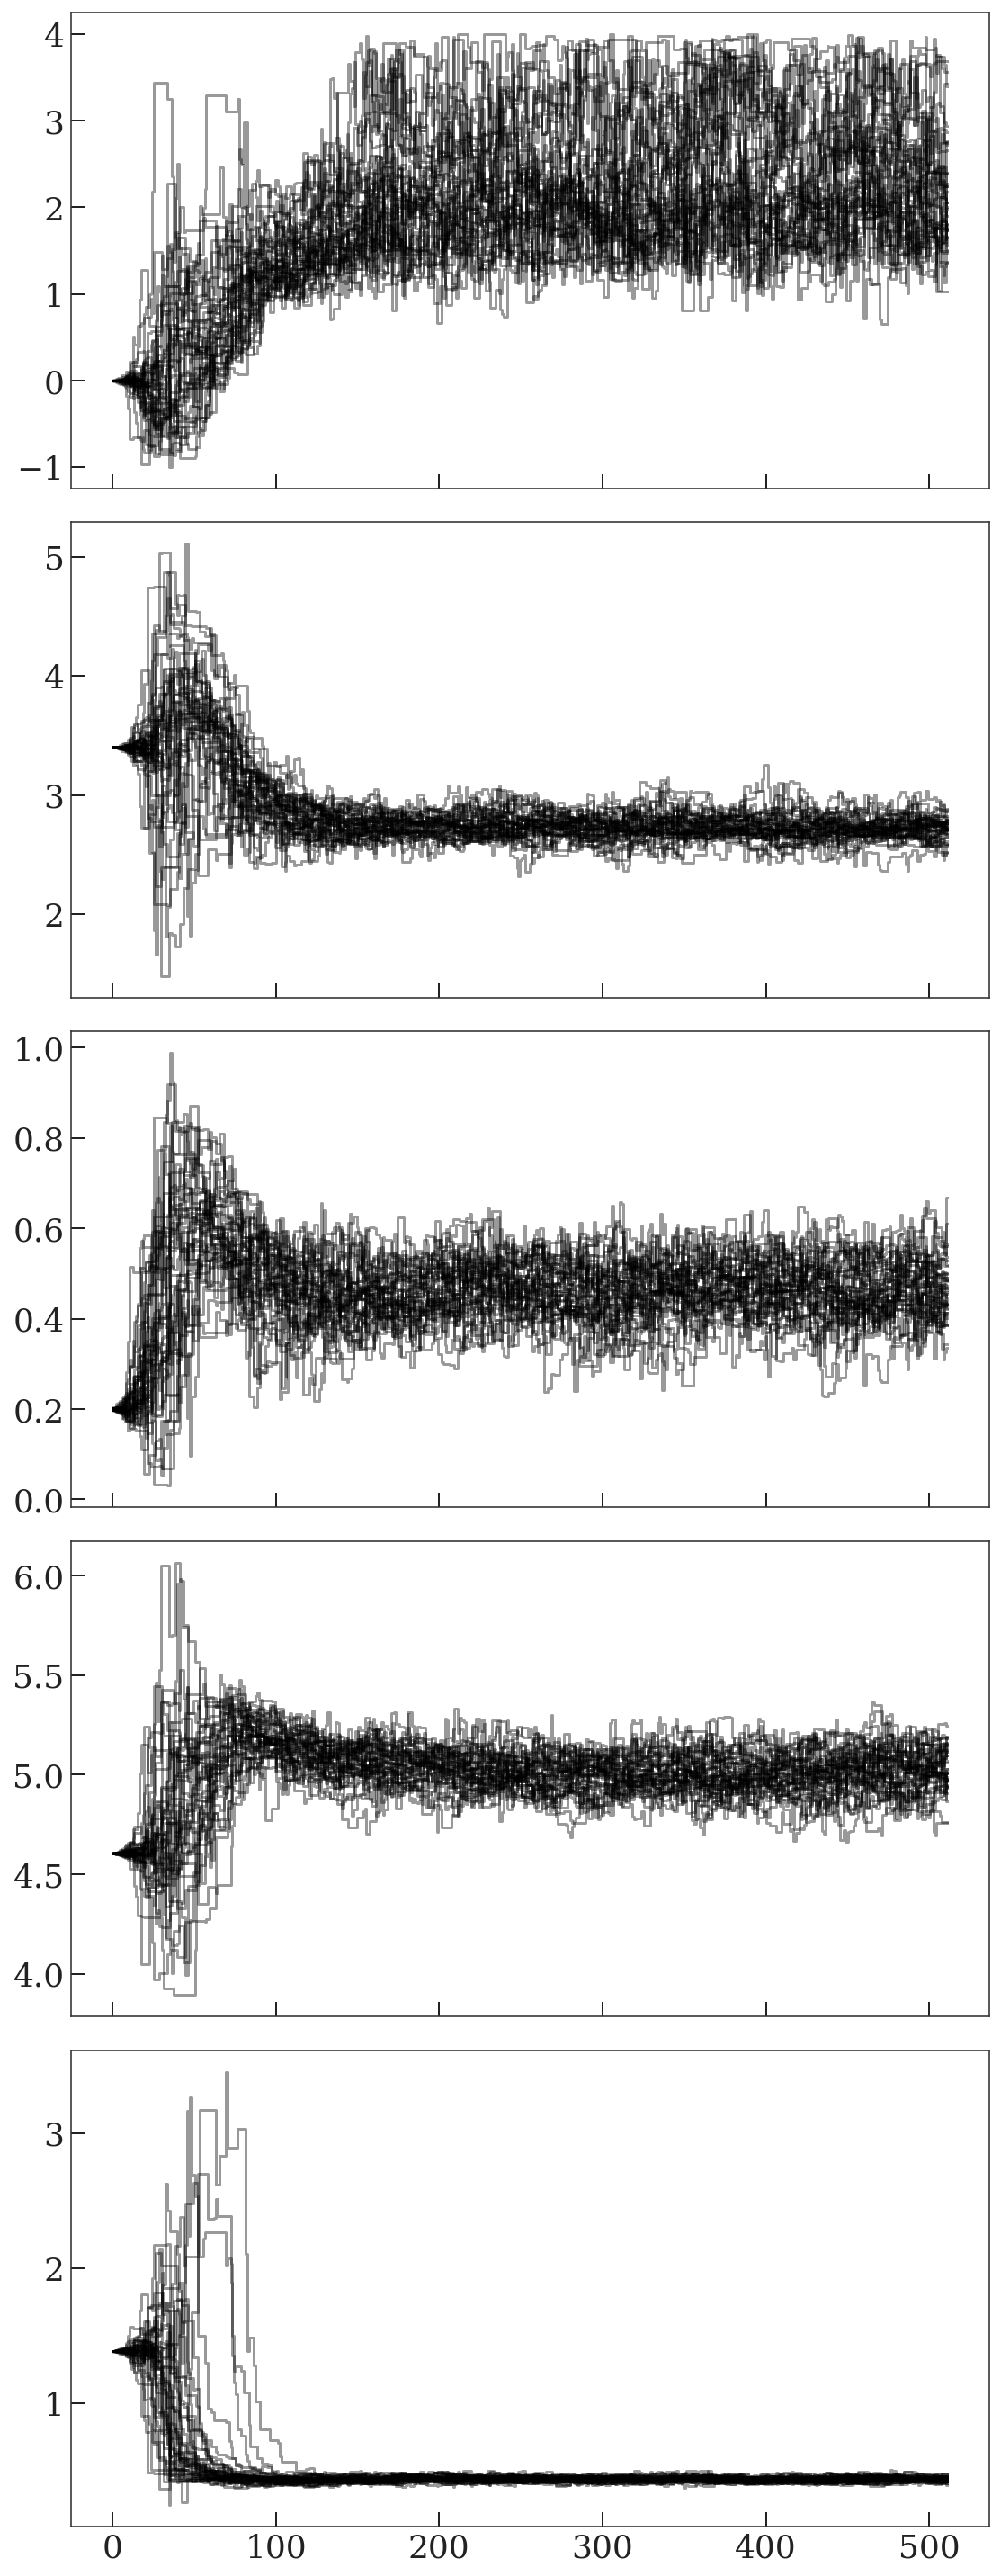

In [38]:
fig, axes = plt.subplots(nparams, 1, figsize=(8, 4*nparams), 
                         sharex=True)

for k in range(sampler.chain.shape[-1]):
    for walker in sampler.chain[..., k]:
        axes[k].plot(walker, marker='', 
                     drawstyle='steps-mid', alpha=0.4, color='k')        
fig.tight_layout()

In [39]:
pp = mod.unpack_pars(sampler.chain[0, -1])

In [40]:
zgrid = np.linspace(mod._zlim[0], mod._zlim[1], 252)
egrid = np.linspace(0, 1, 256)
zz, ee = np.meshgrid(zgrid, egrid)

lnval_init = np.sum(mod.ln_ze_dens(mod.unpack_pars(p0), ee, zz), axis=0)
lnval_min = np.sum(mod.ln_ze_dens(mod.unpack_pars(res.x), ee, zz), axis=0)
lnval_emcee = np.sum(mod.ln_ze_dens(pp, ee, zz), axis=0)

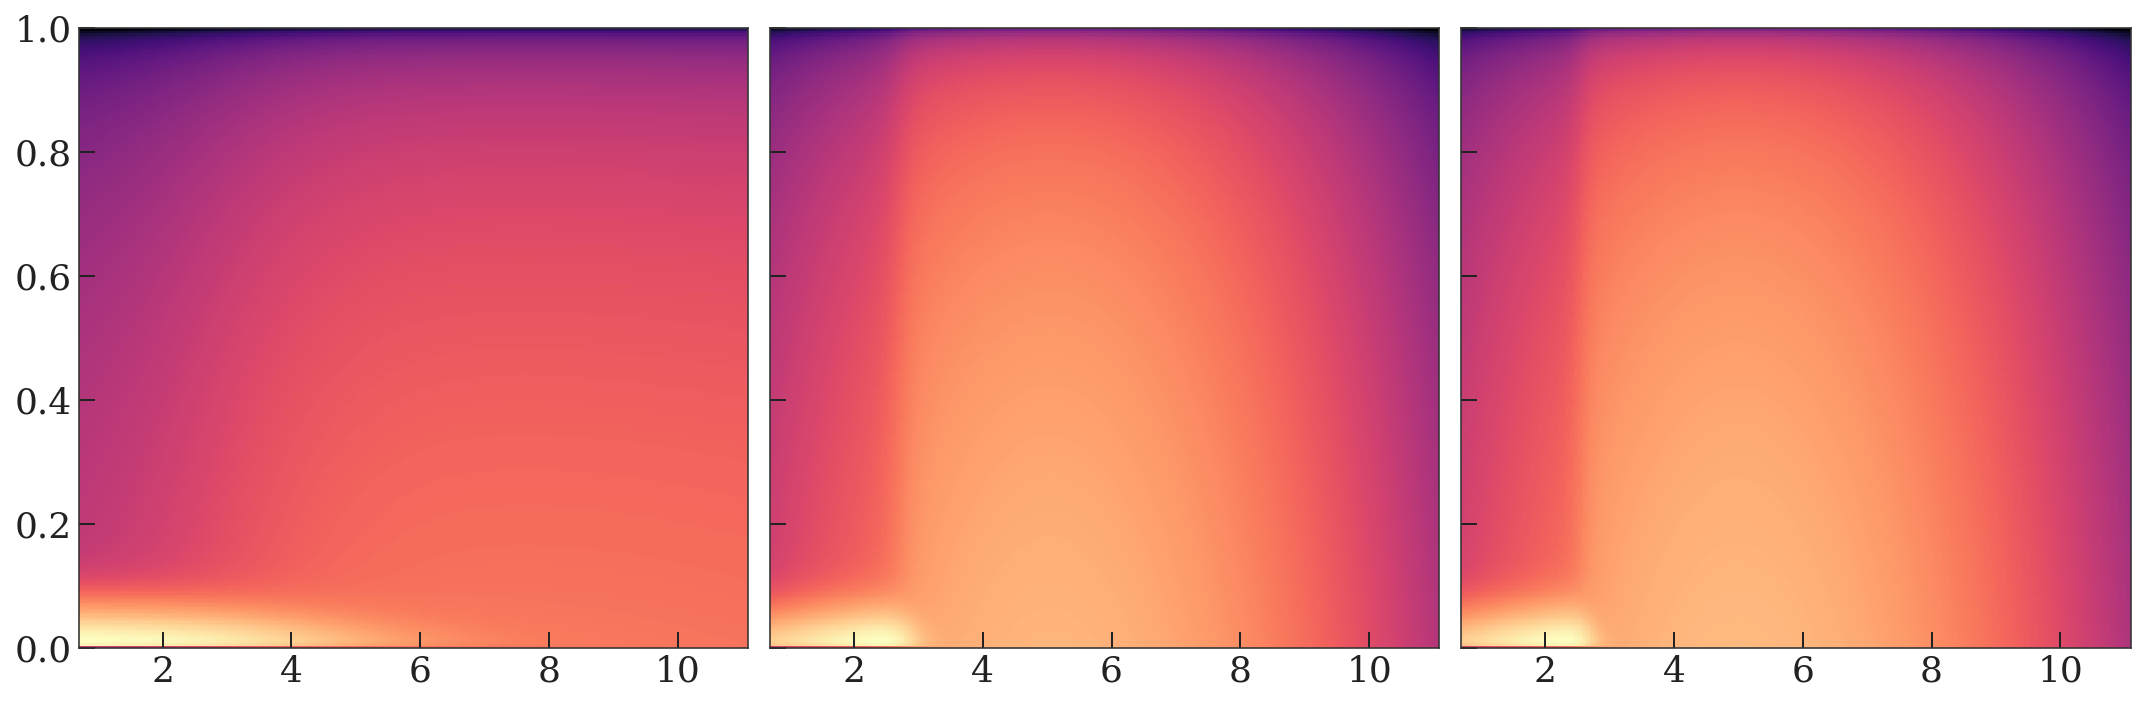

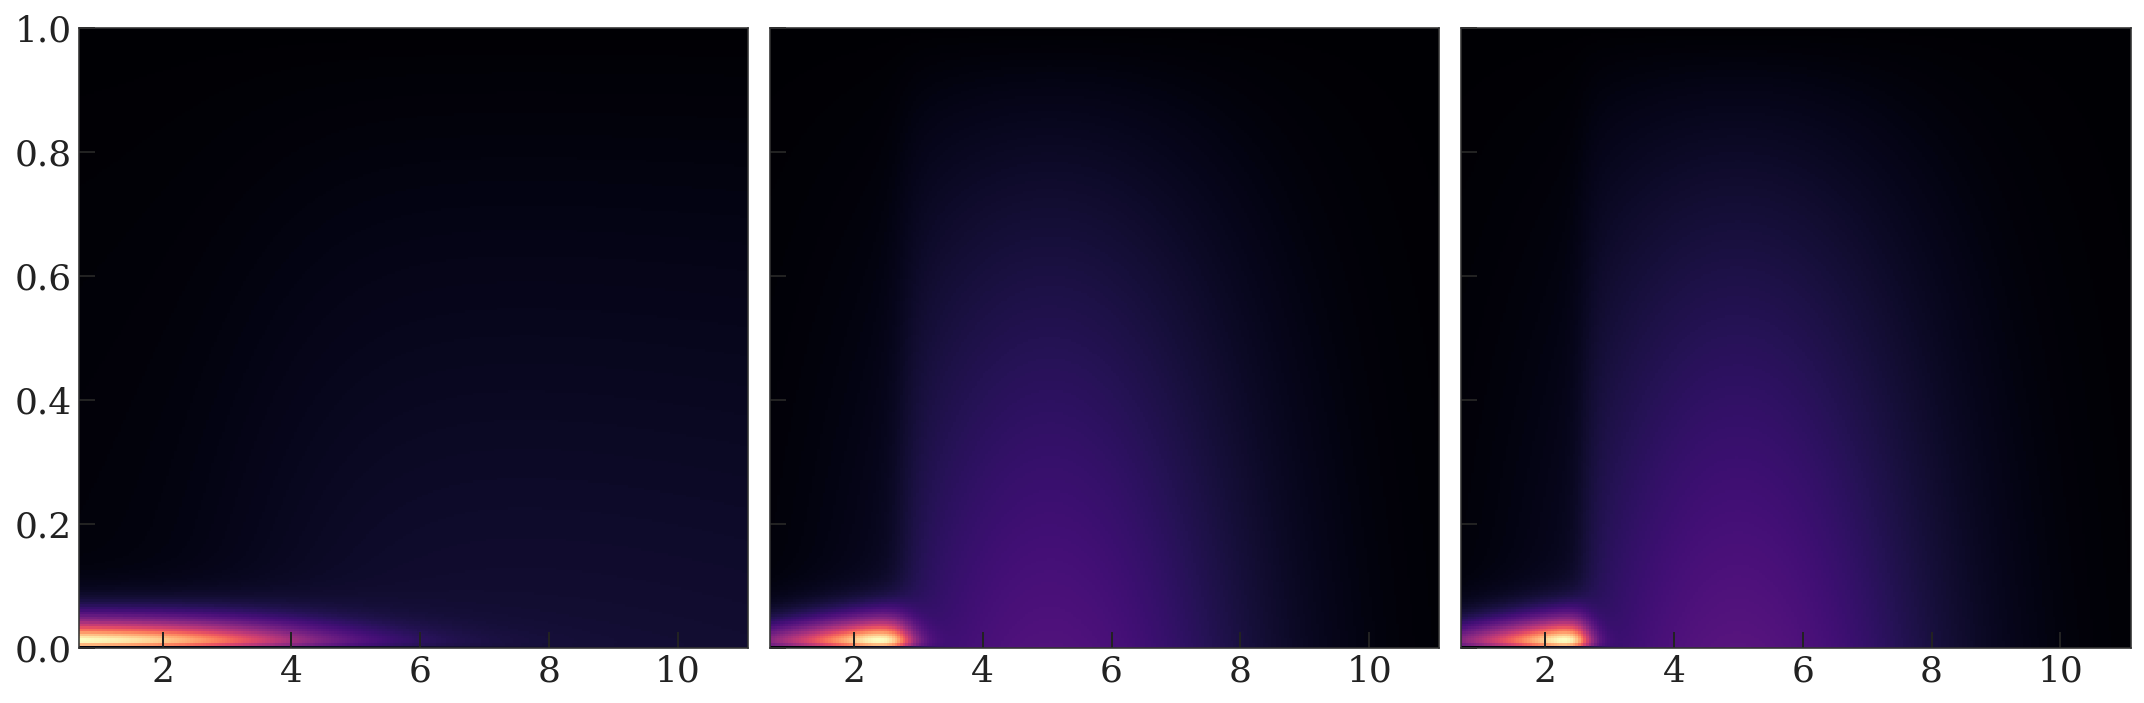

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axes[0].pcolormesh(zz, ee, lnval_init)
axes[1].pcolormesh(zz, ee, lnval_min)
axes[2].pcolormesh(zz, ee, lnval_emcee)
fig.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
axes[0].pcolormesh(zz, ee, np.exp(lnval_init))
axes[1].pcolormesh(zz, ee, np.exp(lnval_min))
axes[2].pcolormesh(zz, ee, np.exp(lnval_emcee))
fig.tight_layout()

(0, 1)

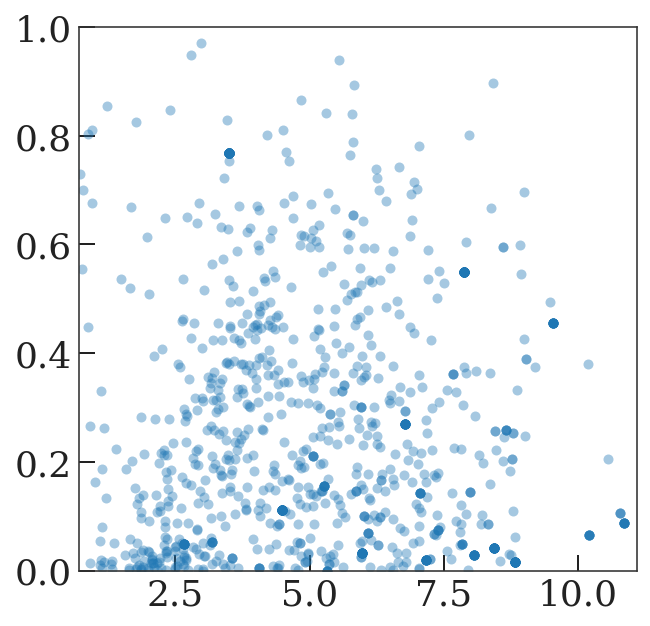

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.plot(ez_samples[1].T, ez_samples[0].T, 
ax.plot(ez_samples[1, :, 0], ez_samples[0, :, 0], 
        marker='o', ls='none', alpha=0.4);
ax.set_xlim(zgrid.min(), zgrid.max())
ax.set_ylim(0, 1)